In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = True

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))        
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data =  pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv")

future_var = ['Dni','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','Dni Future','HourlyDryBulbTemperature Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

N.Y.C. 630990 5785.991561071094 1225.7784954986557
Dni 630990 176.76888857192665 310.5093273356992
HourlyDryBulbTemperature 630990 55.41817575836172 16.948338021415687
Dni Future 630990 176.76888857192665 310.5093273356991
HourlyDryBulbTemperature Future 630990 55.41831082066088 16.948266591608352
   N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future
0  5116.9  0.0                      44.0         0.0                        44.588235
1  5102.1  0.0                      44.0         0.0                        44.686275
2  5074.9  0.0                      44.0         0.0                        44.784314
3  5089.6  0.0                      44.0         0.0                        44.882353
4  5061.3  0.0                      44.0         0.0                        44.980392


In [ ]:
data

,N.Y.C.,Dni,HourlyDryBulbTemperature,Dni Future,HourlyDryBulbTemperature Future
0,5116.9000,0.0,44.0,0.0,44.588235
1,5102.1000,0.0,44.0,0.0,44.686275
2,5074.9000,0.0,44.0,0.0,44.784314
3,5089.6000,0.0,44.0,0.0,44.882353
4,5061.3000,0.0,44.0,0.0,44.980392
...,...,...,...,...,...
630985,4989.4395,0.0,49.0,0.0,48.451613
630986,4943.5040,0.0,49.0,0.0,48.290323
630987,4948.2573,0.0,49.0,0.0,48.129032
630988,4927.0645,0.0,49.0,0.0,48.500000


In [ ]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 176.74872041098973 ;std_s = 310.4973536354869
m_t = 56.030910041113;std_t = 16.507268780702415
#N.Y.C. 631062 5785.801098166661 1225.8381262919374
#Dni 631062 176.74872041098973 310.4973536354869
#HourlyDryBulbTemperature 631062 55.41743325211331 16.947708813988072

m_list = [m,m_s,m_t,m_s,m_t]
std_list = [std,std_s,std_t,std_s,std_t]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


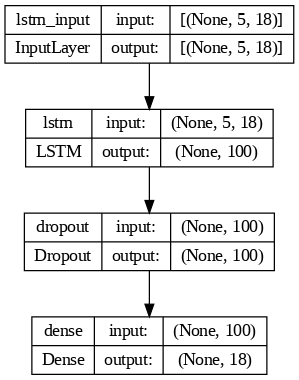

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
model_name = 'test_model_slope_with_solar_weather_future_100.h5'
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=16, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-05 15:12:08.909426
Epoch 1/5
32867/32867 - 187s - loss: 0.0138 - 187s/epoch - 6ms/step
Epoch 2/5
32867/32867 - 180s - loss: 0.0073 - 180s/epoch - 5ms/step
Epoch 3/5
32867/32867 - 184s - loss: 0.0065 - 184s/epoch - 6ms/step
Epoch 4/5
32867/32867 - 190s - loss: 0.0061 - 190s/epoch - 6ms/step
Epoch 5/5
32867/32867 - 185s - loss: 0.0059 - 185s/epoch - 6ms/step


3284/3284 [==============================] - 12s 4ms/step
Total Test Score: 288.24 RMSE
90 Min Test Score: 104.79 RMSE
Relative Test Score: 1.81 perc RMSE


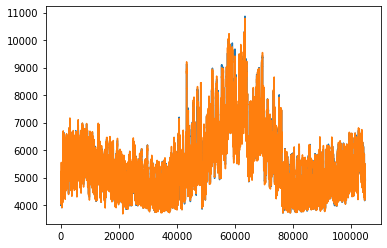

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

# Load prediction with weather correction

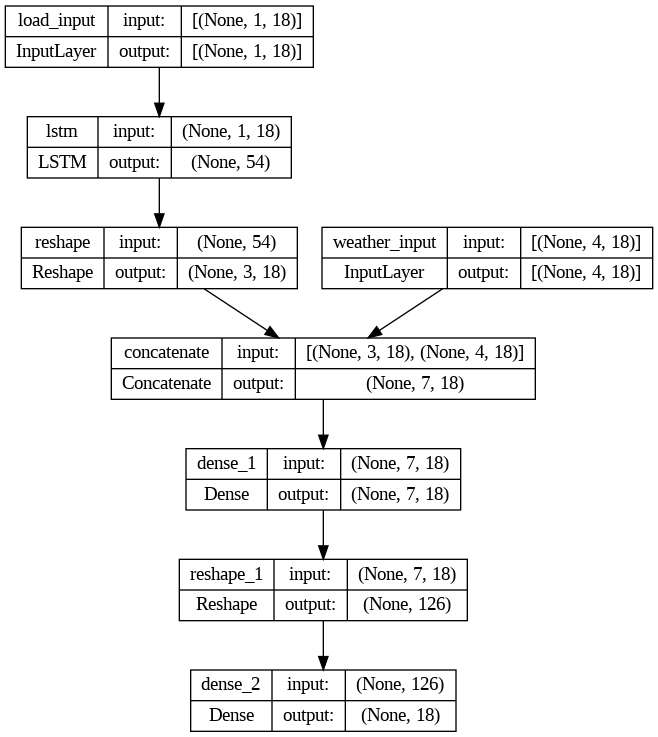

In [ ]:
def create_multi_input_model(recurrent_dropout=0.05,lstm_multiple = 3,
                      learning_rate=0.00005,var_num = 4,
                      hist_window=18,forecast_window=18):
  
  load_input = ly.Input(shape=(1,hist_window), name='load_input')
  weather =  ly.Input(shape=(var_num,hist_window), name='weather_input')
  lstm = ly.LSTM(lstm_multiple * hist_window,  recurrent_dropout=recurrent_dropout, name = 'lstm')(load_input)
  lstm = ly.Reshape((lstm_multiple, hist_window))(lstm)
  all_input = ly.Concatenate(axis=1)([lstm, weather])
  forcast = ly.Dense(forecast_window)(all_input)
  forcast = ly.Reshape(((var_num+lstm_multiple)*hist_window,))(forcast) # can use a convolution layer here? 
  forcast = ly.Dense(forecast_window)(forcast)

  model = Model(inputs = [load_input, weather], outputs = [forcast])

  return model
model = create_multi_input_model() 
plot_model (model, show_shapes=True)

In [ ]:
# def model_train(model, load_input, weather_input, load_target):
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
model_name = 'test_LSTM_mulyi_input.h5'

# model = create_multi_input_model()
model.compile(loss='mean_squared_error', optimizer='adam')
if train_b:
  model_hist = model.fit([train[:,0:1,:], train[:,1:,:]], label_t, epochs=5)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

Epoch 1/5
16434/16434 [==============================] - 92s 5ms/step - loss: 0.0113
Epoch 2/5
16434/16434 [==============================] - 84s 5ms/step - loss: 0.0062
Epoch 3/5
16434/16434 [==============================] - 83s 5ms/step - loss: 0.0060
Epoch 4/5
16434/16434 [==============================] - 81s 5ms/step - loss: 0.0059
Epoch 5/5
16434/16434 [==============================] - 81s 5ms/step - loss: 0.0058


In [ ]:
pred = model.predict([train[:,0:1,:], train[:,1:,:]])

16434/16434 [==============================] - 40s 2ms/step


3284/3284 [==============================] - 8s 2ms/step
Total Test Score: 344.55 RMSE
90 Min Test Score: 136.07 RMSE
Relative Test Score: 2.35 perc RMSE


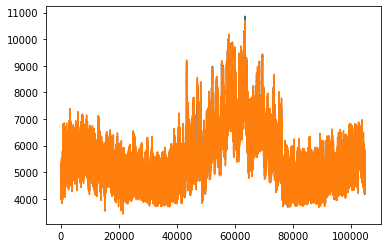

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict([valid[:,0:1,:], valid[:,1:,:]])

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()